# Read in the data from Charles El Mir and output to "raw"

*The data are from [this article](https://www.sciencedirect.com/science/article/pii/S001910351830349X?via%3Dihub).*

*I will have to downsample considerably...*


In [1]:
import pandas as pd
import numpy as np
import os

### Get the total number of objects in all files

*The number of particles decreases as the time increases, but it's always around 1M.  We want about 1M objects total.  So the fraction that we will use in each file is about 1/Nfiles.*

In [2]:
fs = os.listdir()
files = []
nfiles = 0
for f in fs:
    if ('csv' in f):
        files.append(f)
#print(files)
nfiles = len(files)
frac = 1./nfiles * 0.01 #to speed up everything for testing
print(frac)        


0.00010752688172043012


### Grab a list of IDs from the first file

In [3]:
f = 'grav.000000000.csv'
df = pd.read_csv(f, header=None, names=['ID','x','y','z','color'])
time = float(f[5:14])
df['time'] = time
dfSample = df.sample(frac=frac)
print(dfSample.shape)
print(dfSample)

(109, 6)
          ID             x             y             z  color  time
110925   0.0  -9900.010548   3100.003303  -3900.004155    3.0   0.0
629764   0.0   1700.001811   4300.004582  -6300.006713    5.0   0.0
702281   0.0   3900.004155  10900.011614   4300.004582    2.0   0.0
863143   0.0   6300.006713  -1100.001172  -1900.002024    3.0   0.0
529993   0.0  -3500.003729   1500.001598   2100.002238    2.0   0.0
1008315  0.0   4500.004795   9100.009696   6500.006926    2.0   0.0
14959    0.0  -6700.007139  -6500.006926  -4700.005008    5.0   0.0
23993    0.0  -6700.007139  -8700.009270  -2700.002877    3.0   0.0
10977    0.0  -6500.006926  -6500.006926  -5500.005860    5.0   0.0
438532   0.0  -1700.001811    900.000959  -9500.010122    3.0   0.0
355589   0.0  -1700.001811 -10900.011614   1100.001172    3.0   0.0
72195    0.0  -4300.004582   1300.001385 -11900.012679    3.0   0.0
342343   0.0  -2900.003090  -6700.007139   -700.000746    3.0   0.0
518649   0.0   -300.000320    700.00074

### Read through all the files, and only keep the rows that match these IDs

In [4]:
dfOut = dfSample.copy()
for i,f in enumerate(files):
    if (i > 0):
        df = pd.read_csv(f, header=None, names=['ID','x','y','z','color'])
        time = float(f[5:14])
        df['time'] = time
        #dfUse = df.loc[df['ID'].isin(dfSample['ID'].values)] #IDs are not correct in Charles' file
        dfUse = df.sample(frac=frac) #for now
        dfOut = dfOut.append(dfUse, ignore_index=True)
        print(f, dfOut.shape, dfUse.shape)



grav.000001000.csv (218, 6) (109, 6)
grav.000002000.csv (327, 6) (109, 6)
grav.000003000.csv (436, 6) (109, 6)
grav.000004000.csv (545, 6) (109, 6)
grav.000005000.csv (654, 6) (109, 6)
grav.000006000.csv (762, 6) (108, 6)
grav.000007000.csv (870, 6) (108, 6)
grav.000008000.csv (978, 6) (108, 6)
grav.000009000.csv (1085, 6) (107, 6)
grav.000010000.csv (1192, 6) (107, 6)
grav.000011000.csv (1298, 6) (106, 6)
grav.000012000.csv (1404, 6) (106, 6)
grav.000013000.csv (1510, 6) (106, 6)
grav.000014000.csv (1615, 6) (105, 6)
grav.000015000.csv (1720, 6) (105, 6)
grav.000016000.csv (1824, 6) (104, 6)
grav.000017000.csv (1928, 6) (104, 6)
grav.000018000.csv (2032, 6) (104, 6)
grav.000019000.csv (2135, 6) (103, 6)
grav.000020000.csv (2238, 6) (103, 6)
grav.000021000.csv (2341, 6) (103, 6)
grav.000022000.csv (2443, 6) (102, 6)
grav.000023000.csv (2545, 6) (102, 6)
grav.000024000.csv (2647, 6) (102, 6)
grav.000025000.csv (2749, 6) (102, 6)
grav.000026000.csv (2851, 6) (102, 6)
grav.000027000.csv (

## Write to "raw" file

*This is extremely slow because I want to match the IDs*

In [12]:
import csv
csvfile = open("asteroid.raw", 'wt')
csvwriter = csv.writer(csvfile, delimiter=' ', quotechar='|', quoting=csv.QUOTE_MINIMAL)
for i in range(len(dfOut['ID'])):
    ID = dfOut['ID'].values[i]
    sameID = dfOut.loc[(dfOut['ID'] == ID) & (dfOut.index > i)]
    r,c = sameID.shape
    if (r == 0):
        sameID = dfOut.iloc[i].copy()
        sameID = sameID.append(dfOut.iloc[i].copy()) #so that I get a list of values
        
    csvwriter.writerow([dfOut['x'].values[i],dfOut['y'].values[i],dfOut['z'].values[i], 
                        sameID['x'].values[0],sameID['y'].values[0],sameID['z'].values[0],
                        dfOut['time'].values[i], dfOut['color'].values[i], dfOut['ID'].values[i]])
csvfile.close()

problem


## Plot the files

(-20000.0, 20000.0, -25000.0, 20000.0)

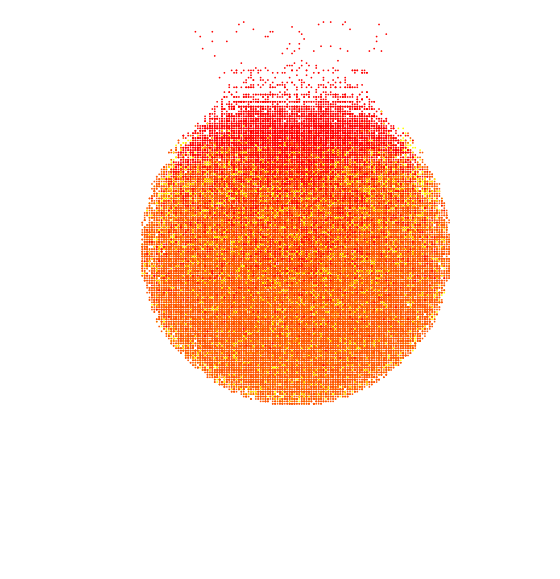

In [6]:
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML
%matplotlib inline

i=0
f = files[i]
#f = 'grav.000000000.csv'
#f = 'grav.000092000.csv'
df = pd.read_csv(f, header=None, names=['ID','x','y','z','color'])
dfUse = df.sample(frac = 0.1)

fig,ax = plt.subplots(figsize=(10,10))
scat = ax.scatter(dfUse['x'].values, dfUse['y'].values, s=0.5, c=dfUse['color'].values, cmap='autumn')
ax.set_xlim(-20000, 20000)
ax.set_ylim(-25000, 20000)
ax.set_aspect('equal')
ax.axis('off')

In [7]:
%%capture
%matplotlib inline
plt.rcParams["animation.html"] = "jshtml"

f = files[0]
df = pd.read_csv(f, header=None, names=['ID','x','y','z','color'])
dfUse = df.sample(frac = 0.1)

fig,ax = plt.subplots(figsize=(10,10))
scat = ax.scatter(dfUse['x'].values, dfUse['y'].values, s=0.5, c=dfUse['color'].values, cmap='autumn')
ax.set_xlim(-20000, 20000)
ax.set_ylim(-25000, 20000)
ax.set_aspect('equal')
plt.axis('off')

def update_plot(i):
    f = files[i]
    df = pd.read_csv(f, header=None, names=['ID','x','y','z','color'])
    dfUse = df.sample(frac = 0.1)
    # Change the colors.
    scat.set_array(dfUse['color'].values)
    # Change the x,y positions. This expects a _single_ 2xN, 2D array
    scat.set_offsets(np.hstack((dfUse['x'].values, dfUse['y'].values)))
    fig.canvas.draw()
    return scat,


anim = animation.FuncAnimation(fig, update_plot, frames=len(files), interval=50)

In [8]:
anim

In [34]:
HTML(anim.to_html5_video())

KeyboardInterrupt: 